# Определение фронтира

**Фронтир** - некоторая фундаментальная концепция, являющася точкой ростой множества прикладных исследований
и их последующей успешной коммерциализации.

*Пример - глубокое обучение.*

## Подготовительный код получения вложений статей arxiv

1. С kaggle можно взять датасет статей arxiv.org, почистить-причесать немного,
2. С помощью сетки allenai/scibert - насчитать вложения для  абстрактов статей,

Работает в Google Colab **_Pro_**.

In [1]:
!pip install umap-learn transformers==4.6.1 keybert

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 2.3MB 45.8MB/s 
     |████████████████████████████████| 1.2MB 44.3MB/s 
     |████████████████████████████████| 901kB 53.7MB/s 
     |████████████████████████████████| 3.3MB 63.7MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 1.2MB 39.0MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=3574058ba4259cfb0269c7bdc104387c904a4d0ae7bc72f7d73e52b7940026e2
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for keybert: filename=keybert-0.3.0-cp37-none-any.whl size=19436 sha256=01a2b76fce15f430578d248d0e41ab7cd0a2fc02c213fb4847cdbffda6f88408
  Stored in directory: /root/.cache/pip/wheels/0c/ab/2b/bc129895ee956866333f364f1b3beb20efa788e074c03e6b34
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51

In [153]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import umap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from scipy.signal import find_peaks

from sklearn.utils import shuffle
from datetime import date

import tensorflow as tf
import keras
from IPython.display import clear_output

import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.cluster import AgglomerativeClustering

import keybert

import gc
import os

from tqdm import tqdm

In [3]:
%%time

# https://www.kaggle.com/Cornell-University/arxiv
all_papers = pd.read_json(
    '/content/drive/MyDrive/data/arxiv-metadata-oai-snapshot.json',
    lines=True
)

def extract_created(value):
  return value[0]['created']

all_papers['created'] = all_papers['versions'].apply(extract_created)

CPU times: user 50.1 s, sys: 11.7 s, total: 1min 1s
Wall time: 1min 28s


In [4]:
%%time

needed_columns = ['created', 'abstract', 'title', 'categories']
papers = all_papers[needed_columns].copy()

# подмножество всех статей
subset = 40 * 1000

papers['date'] = pd.to_datetime(papers.created.values)
papers = papers[papers['date'] >= '2009-01-01']

indices = shuffle(np.arange(len(papers)), random_state=1)[:subset]
papers = papers.iloc[indices].copy()

if 'all_papers' in globals():
  del all_papers
gc.collect();

CPU times: user 4min 19s, sys: 1.26 s, total: 4min 20s
Wall time: 4min 19s


In [5]:
papers.date.describe().T

count                         40000
unique                        39976
top       2012-03-15 11:17:56+00:00
freq                              5
first     2009-01-02 12:47:47+00:00
last      2021-05-27 17:34:31+00:00
Name: date, dtype: object

In [6]:
cuda_tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', use_fast=True)
cuda_model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
cuda_model.to('cuda:0');

def inference(texts_list):
  data = cuda_tokenizer(texts_list, truncation=True, padding=True, max_length=400, return_tensors='pt')
  for key in data:
    data[key] = data[key].cuda()
  return cuda_model(**data)['pooler_output'].detach().cpu().numpy()

def infer(sliced):
  return inference(papers['abstract'].values[sliced].tolist())

step = 200
embeddings = None

for index in tqdm(range(0, len(papers), step), position=0, leave=True):
  torch.cuda.empty_cache()
  with torch.no_grad():
    current = infer(slice(index, index + step))
  if embeddings is None:
    embeddings = current
  else:
    embeddings = np.concatenate([embeddings, current])
  gc.collect()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 200/200 [09:40<00:00,  2.90s/it]


In [7]:
assert len(embeddings) == len(papers)
print('ok')

ok


# Код обучения и проверки

Идея идентификации фронтиров заключена в следующем:
1. Вкладываем с помощью `UMAP` подвыборку всех вложений абстрактов в двумерное пространство,
2. Кластеризуем,
3. Берем биржевые индексы отраслей США (с finam.ru),
4. Для них строим таргет: от даты время до пика, величина пика,
5. Учим простую сетки для каждого индекса, на входе средние компоненты после `umap` по всем кластерам (сколько бы их ни было) на дату, и усредненные за `history` последних дней arxiv, на выходе - таргет (дата до пика и величина пика - два выхода),
6. Для определения наиболее повлиявшего кластера проворачиваем ~~фарш~~ градиенты в обратную сторону (почти `grad-cam`, но проще),
7. Какой индекс дал наибольший вклад - тот "папа"-кластер. Смотрим что в него входит, какие абстракты - все конкатенируем,
8. Извлекаем облако слов и получаем некоторое описание фронтира.

In [71]:
path = '/content/drive/MyDrive/data/finam/'

def get_target_data(window=180, start_date='2010-01-01', end_date='2022-01-01'):
  ticker_files = [
    filename for filename in os.listdir(path) if filename.endswith('.csv')
  ]

  result = {}
  name_slice = slice(8, 12)

  for file in ticker_files:
    frame = pd.read_csv(path + file, parse_dates=['<DATE>'])
    frame = frame.dropna()
    frame['<CLOSE>'] = frame['<CLOSE>'].apply(lambda value: '.'.join(str(value).split('.')[:2])).astype(np.float)
    series = frame.set_index('<DATE>')['<CLOSE>'].resample('1D').interpolate().sort_index()
    series = series[series.index >= start_date]
    series = series[series.index < end_date]
    series = series.rolling(window=window, center=True).mean().dropna()
    result[file[name_slice]] = series

  result = pd.DataFrame(result)
  result['US22'] = result.mean(axis=1)

  return result

# возвращает пару (дней до пика, величина пика)
def get_pair(serie, width=40):
  peaks = find_peaks(serie, width=width)[0]
  if len(peaks):
    return [
      (serie.index[peaks[0]] - serie.index[0]).days, serie[peaks[0]]
    ]
  else:
    return None

In [329]:
%%time

def map_and_cluster(n_clusters=100):
  mapper = umap.UMAP(
    n_neighbors=5, min_dist=0.01, n_components=3, metric='cosine',
    random_state=1
  )
  
  timed_embeddings = np.copy(embeddings)
  timed_embeddings[:, -1] = np.array(indices) / (2 * 1000 * 1000)

  mapped = mapper.fit_transform(timed_embeddings)

  clusterer = AgglomerativeClustering(
      n_clusters=n_clusters, memory='/tmp/'
  ).fit(mapped)

  return mapped, clusterer

mapped, clusterer = map_and_cluster()
print('Количество промежуточных узлов в дереве', clusterer.n_connected_components_)

Количество промежуточных узлов в дереве 1
CPU times: user 35.5 s, sys: 1.33 s, total: 36.9 s
Wall time: 28.9 s


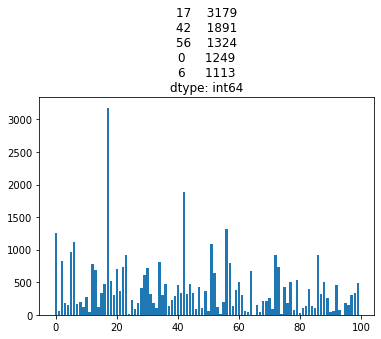

In [327]:
plt.title('%s' % pd.value_counts(clusterer.labels_)[:5])
plt.bar(
    pd.value_counts(clusterer.labels_).index, pd.value_counts(clusterer.labels_).values
);

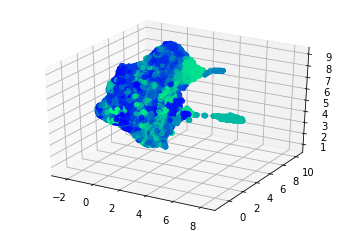

In [328]:
axes = plt.subplot(projection='3d')
axes.scatter(
    mapped[:, 0],
    mapped[:, 1],
    mapped[:, 2],
    c=clusterer.labels_,
    cmap='winter'
);

In [275]:
# начинаем делать данные для обучения

dataset = papers.copy()
dataset['umap_0'] = mapped[:, 0]
dataset['umap_1'] = mapped[:, 1]
dataset['umap_2'] = mapped[:, 2]
dataset['cluster'] = clusterer.labels_

data = dataset.set_index('date').sort_index()[
  ['umap_0', 'umap_1', 'umap_2', 'cluster']
]

# выкидываем торговые войны и COVID-19
end_date = '2018-10-01'
data = data[data.index <= end_date]

'Количество вложенных в 3D статей', len(data)

('Количество вложенных в 3D статей', 27209)

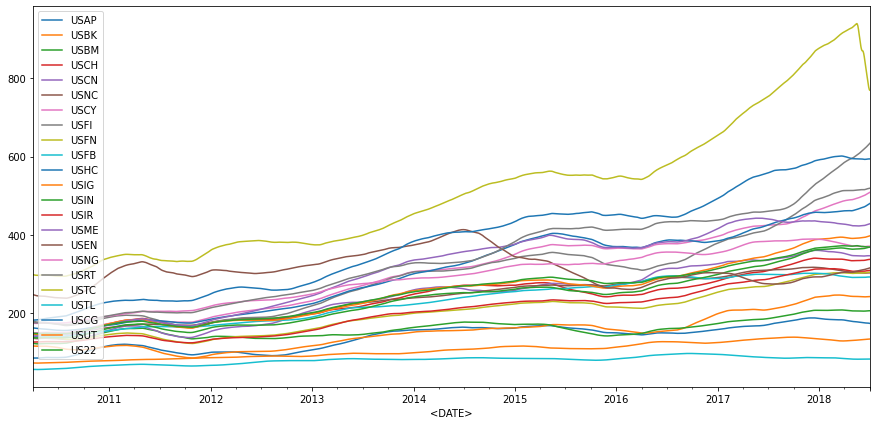

In [276]:
target = get_target_data(end_date=end_date)
target.plot(figsize=(15, 7));

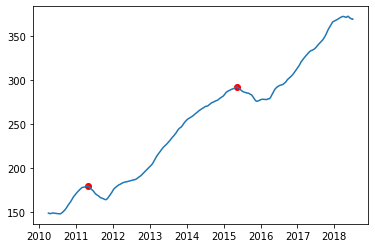

In [336]:
check_day, check_peak = get_pair(target['US22'])
plt.plot(target['US22'].index, target['US22'].values);
plt.scatter(target['US22'].index[check_day], check_peak, c='red');
check_day_next, check_peak = get_pair(target['US22'][check_day:])
plt.scatter(target['US22'].index[check_day + check_day_next], check_peak, c='red');

In [385]:
excel_path = '/content/drive/MyDrive/data/gem/'
excel_data = {}

for name in os.listdir(excel_path):
  try:
    current_excel = pd.read_excel(excel_path + name, sheet_name='monthly')
    current_excel = current_excel.rename({'Unnamed: 0': 'date'}, axis='columns')
    # current_excel.columns = ['date', 'world']
    current_excel['date'] = pd.to_datetime(list(map(
        lambda value: pd.datetime(int(str(value)[:4]), int(str(value)[-2:]), 1) if str(value) != 'nan' else np.nan,
        current_excel.date.values.tolist()
    )))
    current_excel = current_excel[
      ['Advanced Economies', 'World (WBG members)', 'date']
    ].set_index('date').resample('D').interpolate().dropna()
    current_excel = current_excel[
      (current_excel.index >= target.index.min()) & (current_excel.index <= target.index.max())
    ]
    excel_data[name[:-5]] = current_excel
  except Exception as exception: # нет помесячных данных
    print(str(exception))

[(key, len(excel_data[key])) for key in excel_data]

No sheet named <'monthly'>


[('Retail_Sales_Volume_Index_seas_adj', 3016),
 ('IndustrialProduction_constant_2010_US$_seas_adj', 3016)]

In [387]:
assert len(excel_data['Retail_Sales_Volume_Index_seas_adj']) == len(target)
assert len(excel_data['IndustrialProduction_constant_2010_US$_seas_adj']) == len(target)
print('ok')

ok


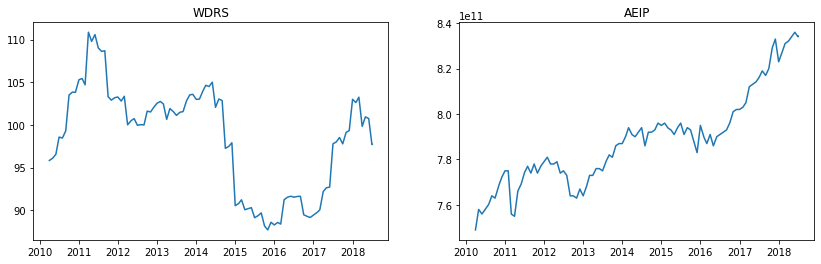

In [409]:
target['AEIP'] = excel_data['IndustrialProduction_constant_2010_US$_seas_adj'].values[:, 0]
target['WDRS'] = excel_data['Retail_Sales_Volume_Index_seas_adj'].values[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].set_title('WDRS')
ax[0].plot(target['WDRS']);
ax[1].set_title('AEIP')
ax[1].plot(target['AEIP']);

In [410]:
# сгрупируем маппинги статей кластеров на дату
# и сделаем каждый кластер колонкой из 3-х значений
# назовем их umap_i_j, i - номер компоненты, j - номер кластера

grouped = data.groupby(['date', 'cluster'])[['umap_0', 'umap_1', 'umap_2']].mean().reset_index()
grouped = grouped.pivot(index='date', columns=['cluster'], values=['umap_0', 'umap_1', 'umap_2']).fillna(0).reset_index()
grouped.columns = ["_".join([str(pair[0]), str(pair[1])]) for pair in grouped.columns]

In [411]:
gc.collect()
# насчитаем для тренировки X и y

# сколько последних компонент UMAP усреднять
history = 100

mapped_columns = list(grouped.columns)
mapped_columns.remove('date_')

clusters_number = len(data.cluster.unique())
X_ = grouped[mapped_columns].values

X = []
y_ = {indicator: [] for indicator in target.columns}
target_dates = {}

for indicator in tqdm(y_, position=0, leave=True):
  values = target[indicator].copy()
  indexed = []
  for check in values.index:
    if len(grouped.date_ == check.tz_localize('UTC')) > 0:
      indexed.append(check)
  values = values[np.isin(values.index, indexed)]
  target_dates[indicator] = values.index.copy()
  for index in range(history, len(values)):
    pair = get_pair(values[index:])
    if pair is None:
      continue
    # X насчитываем один раз
    if indicator == 'US22':
      X_array = np.array(X_[index - history:index]).reshape(history, -1)
      X_array = np.mean(X_array, axis=0)
      X.append(X_array.tolist())
    y_[indicator].append(pair)

X = np.array(X).reshape(-1, clusters_number * 3)
y = {
  key: np.array(y_[key]).reshape(len(y_[key]), -1) for key in y_
}

print()
print('X shape', X.shape, 'indicator shape', y['USAP'].shape)

100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


X shape (2776, 300) indicator shape (2675, 2)


Всё, учим наши сеточки

In [289]:
def create_model():
  model = keras.Sequential([
    keras.layers.Dense(128, input_shape=(clusters_number * 3,), activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='linear')
  ])

  model.compile('adam', 'mse')
  return model

In [290]:
def train(indicator, training):
  keras.backend.clear_session()
  gc.collect()

  y_mean = y[indicator][:training].mean(axis=0)
  y_std = y[indicator][:training].std(axis=0)

  target_y = (y[indicator] - y_mean) / y_std
  length = min([training, len(X), len(target_y)])

  model = create_model()
  model.fit(
      *shuffle(X[:length], target_y[:length], random_state=1),
      batch_size=100,
      epochs=100,
      verbose=False
  );
  return model, y_mean, y_std

In [441]:
def gradient_importance(x, model):
    x = tf.Variable(np.array(x).reshape(-1, clusters_number * 3), dtype=tf.float32)

    gradient_model = keras.Model(model.inputs, model.output)

    with tf.GradientTape() as tape:
        y = gradient_model(x)

    return tape.gradient(y, x).numpy()

def get_clusters(importances, top=1):
  sorts = np.argsort(importances.flatten())[-top:]
  return [
    index % clusters_number for index in sorts
  ]

def cluster_description(indicator, index, check_clusters, keyer):
  date_start = target_dates[indicator][index].tz_localize('UTC') - pd.Timedelta(days=history)
  date_end = target_dates[indicator][index].tz_localize('UTC')
  chosen_papers = dataset[(np.isin(dataset.cluster, check_clusters)) & (
    (date_start <= dataset.date) & (dataset.date <= date_end) 
  )][-history:]
  texts = ' '.join(chosen_papers.abstract.apply(
      lambda string: string.replace('\n', ' ')
  ).values.tolist())
  keywords = keyer.extract_keywords(
    texts, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=40
  )
  titles = {}
  for abstract, title in chosen_papers[['abstract', 'title']].values.tolist():
    for keyword, _ in keywords:
      if keyword in abstract:
        if title not in titles:
          titles[title] = 0
        titles[title] += 1
  titles_counts = list(sorted(list(titles.items()), key=lambda entry: entry[1]))
  return keywords, titles_counts[-5:]

In [412]:
# заведем отсечку

holdout = 200
training = len(X) - holdout
training

2576

In [243]:
def mean_absolute_percentage_error(y_true, y_pred): 
  try:
    return np.mean(np.abs((y_true[y_true != 0] - y_pred[y_true != 0]) / y_true[y_true != 0])) * 100
  except:
    return -1

In [413]:
metrics = []
gc.collect()

for indicator in y:
  entry = {}
  model, y_mean, y_std = train(indicator, training)
  model.save('/content/drive/MyDrive/data/' + indicator + '.h5')
  entry['indicator'] = indicator
  entry['mean_days'] = y_mean[0]
  entry['std_days'] = y_std[0]
  entry['mean_value'] = y_mean[1]
  entry['std_value'] = y_std[1]
  min_length = min([len(X), len(y[indicator])])
  entry['days_test_mae'] = mean_absolute_error(
      y[indicator][min_length-holdout:min_length, 0],
      y_std[0] * model.predict(X[min_length-holdout:min_length])[:, 0] + y_mean[0]
  )
  entry['value_test_mae'] = mean_absolute_error(
      y[indicator][min_length-holdout:min_length, 1],
      y_std[1] * model.predict(X[min_length-holdout:min_length])[:, 1] + y_mean[1]
  )
  entry['days_test_mape'] = mean_absolute_percentage_error(
      y[indicator][min_length-holdout:min_length, 0],
      y_std[0] * model.predict(X[min_length-holdout:min_length])[:, 0] + y_mean[0]
  )
  entry['value_test_mape'] = mean_absolute_percentage_error(
      y[indicator][min_length-holdout:min_length, 1],
      y_std[1] * model.predict(X[min_length-holdout:min_length])[:, 1] + y_mean[1]
  )
  print(indicator, entry)
  metrics.append(entry)

metrics = pd.DataFrame(metrics)

USAP {'indicator': 'USAP', 'mean_days': 315.0407608695652, 'std_days': 198.388459517199, 'mean_value': 153.59387369134842, 'std_value': 27.3667520443525, 'days_test_mae': 86.0897137451172, 'value_test_mae': 10.270415250664515, 'days_test_mape': 141.8224008912483, 'value_test_mape': 5.465579622162352}
USBK {'indicator': 'USBK', 'mean_days': 618.6436335403727, 'std_days': 440.75728735550564, 'mean_value': 180.77915658251354, 'std_value': 27.857663396670148, 'days_test_mae': 393.2264256286621, 'value_test_mae': 41.486951698558016, 'days_test_mape': 443.1467976264453, 'value_test_mape': 16.847252262330894}
USBM {'indicator': 'USBM', 'mean_days': 461.702251552795, 'std_days': 305.35637248718587, 'mean_value': 181.94925534847337, 'std_value': 22.77126466671616, 'days_test_mae': 325.42512619018555, 'value_test_mae': 4.662797368731742, 'days_test_mape': 297.35279463772264, 'value_test_mape': 2.238884482999259}
USCH {'indicator': 'USCH', 'mean_days': 407.9623447204969, 'std_days': 264.399469960

In [414]:
indicators_map = {
    'WDRS': 'World Retail Sales',
    'AEIP': 'Advanced Economies Industrial Production',
    'US22': 'Average 22 Indicators',
    'USAP': 'Automobiles & Parts',
    'USBK': 'Banks',
    'USBM': 'Basic Materials',
    'USCH': 'Chemicals',
    'USCN': 'Construction & Materials',
    'USNC': 'Consumer Goods',
    'USCY': 'Consumer Services',
    'USFI': 'Financial Services',
    'USFN': 'Financials',
    'USFB': 'Food & Beverages',
    'USHC': 'Health Care',
    'USIG': 'Industrial Goods & Services',
    'USIN': 'Industrials',
    'USIR': 'Insurance',
    'USME': 'Media',
    'USEN': 'Oil & Gas',
    'USNG': 'Personal & Household Goods',
    'USRT': 'Retail',
    'USTC': 'Technology',
    'USTL': 'Telecommunications',
    'USCG': 'Travel & Leisure',
    'USUT': 'Utilities'
}

metrics_info = metrics.copy().fillna(-1).sort_values('value_test_mape')
metrics_info['details'] = metrics_info['indicator'].apply(lambda name: indicators_map[name])
metrics_info

indicator  ...                                   details
10      USHC  ...                               Health Care
7       USFI  ...                        Financial Services
17      USRT  ...                                    Retail
6       USCY  ...                         Consumer Services
24      AEIP  ...  Advanced Economies Industrial Production
15      USEN  ...                                 Oil & Gas
21      USUT  ...                                 Utilities
19      USTL  ...                        Telecommunications
4       USCN  ...                  Construction & Materials
14      USME  ...                                     Media
9       USFB  ...                          Food & Beverages
5       USNC  ...                            Consumer Goods
16      USNG  ...                Personal & Household Goods
3       USCH  ...                                 Chemicals
2       USBM  ...                           Basic Materials
23      WDRS  ...                        World Retail Sales
13      USIR  ...                                 Insurance
0       USAP  ...                       Automobiles & Parts
22      US22  ...                     Average 22 Indicators
12      USIN  ...                               Industrials
8       USFN  ...                                Financials
11      USIG  ...               Industrial Goods & Services
1       USBK  ...                                     Banks
20      USCG  ...                          Travel & Leisure
18      USTC  ...                                Technology

[25 rows x 10 columns]

In [415]:
metrics.to_json('/content/drive/MyDrive/data/metrics.json', orient='records', lines=True)
# metrics

In [420]:
metrics = pd.read_json('/content/drive/MyDrive/data/metrics.json', lines=True)

check_indicator = 'WDRS'
check_model = keras.models.load_model('/content/drive/MyDrive/data/' + check_indicator + '.h5')

def postprocess(model, array, indicator):
  line = metrics[metrics['indicator'] == indicator]
  predictions = model.predict(array)
  return (
    (line['mean_days'].values[0] + line['std_days'].values[0] * predictions[:, 0]),
    (line['mean_value'].values[0] + line['std_value'].values[0] * predictions[:, 1])
  )

print('days and value of peak', postprocess(check_model, X[-1:], check_indicator))

days and value of peak (array([281.97925], dtype=float32), array([98.01457], dtype=float32))


In [248]:
class CustomEmbedder(keybert.backend.BaseEmbedder):
  def embed(self, documents, verbose=False):
    gc.collect()
    torch.cuda.empty_cache()
    with torch.no_grad():
      data = cuda_tokenizer(documents, truncation=True, padding=True, max_length=400, return_tensors='pt')
      for key in data:
        data[key] = data[key].cuda()
      result = cuda_model(**data)['pooler_output'].detach().cpu().numpy()
    gc.collect()
    torch.cuda.empty_cache()
    return result

keyer = keybert.KeyBERT(model=CustomEmbedder())

In [442]:
check_clusters = get_clusters(gradient_importance(X[-1], check_model))
print(cluster_description(check_indicator, -1, check_clusters, keyer))

([('updating', 0.6125), ('high throughput', 0.61), ('belief propagation', 0.5944), ('results suggest', 0.585), ('efficiently sequence', 0.5815), ('transmitted codewords', 0.5616), ('guarantees', 0.5611), ('large graphs', 0.5587), ('region attraction', 0.5547), ('computational guarantees', 0.5411), ('oscillators comprising', 0.5398), ('computing optimal', 0.5342), ('received vector', 0.5277), ('required estimating', 0.5272), ('detecting communities', 0.5235), ('large list', 0.5231), ('large number', 0.5212), ('diagonal vector', 0.5191), ('visual classifiers', 0.5165), ('object', 0.5088), ('synchronization definition', 0.5078), ('decoding', 0.5074), ('intuitive understanding', 0.5064), ('function', 0.5034), ('rendering', 0.5022), ('codewords generated', 0.5021), ('utilisation', 0.5011), ('rnbrw gives', 0.5007), ('edge edges', 0.4991), ('robots', 0.4975), ('stability finally', 0.4973), ('bayesian', 0.4972), ('notion regret', 0.4971), ('portion', 0.4969), ('assigning jobs', 0.4967), ('desc

In [443]:
check_clusters = get_clusters(gradient_importance(X[-history], check_model))
print(cluster_description(check_indicator, -history, check_clusters, keyer))

([('speculatively perform', 0.555), ('attacks involve', 0.5538), ('software security', 0.5443), ('modern processors', 0.5144), ('emerging workloads', 0.4899), ('ontologies ontologies', 0.4836), ('nodes represent', 0.4821), ('usually', 0.4779), ('acm artifact', 0.4561), ('isas hardware', 0.4559), ('false beliefs', 0.4493), ('agents behaviour', 0.4492), ('neural network', 0.4488), ('violate security', 0.4373), ('enumerate', 0.4364), ('recursively partitions', 0.4341), ('recursion', 0.4334), ('object', 0.4309), ('method', 0.4306), ('consistent subgraphs', 0.4252), ('network tomnet', 0.4111), ('generalize ontologies', 0.4072), ('recursively', 0.4042), ('automated map', 0.4039), ('combines tallies', 0.4027), ('lidar gis', 0.4023), ('compilation', 0.4), ('maximize', 0.3984), ('branch prediction', 0.398), ('workloads', 0.3969), ('1983 baron', 0.3891), ('graph object', 0.3862), ('ontologies', 0.3795), ('work provides', 0.3783), ('depth analysis', 0.3781), ('intensive hands', 0.3757), ('large s

# Код для production

In [444]:
def create_description(indicator, index, predictor):
  days, value = postprocess(predictor, X[index:index+1], indicator)
  days = days[0]
  value = value[0]
  clusters = get_clusters(gradient_importance(X[index], model))
  wordcloud, titles = cluster_description(indicator, index, clusters, keyer)
  date = target_dates[indicator][index]
  return {
      'date': str(date),
      'words': list(map(lambda pair: list(pair), wordcloud)),
      'titles': list(map(lambda pair: list(pair), titles)),
      'days': days,
      'value': value
  }

create_description(check_indicator, -history, check_model)

{'date': '2018-03-26 00:00:00',
 'days': 215.87018,
 'titles': [['Dimensional Analysis in Economics: A Study of the Neoclassical Economic\n  Growth Model',
   1],
  ['New definition of complexity for self-gravitating fluid distributions:\n  The spherically symmetric, static case',
   4],
  ['Derivation and analysis of the nonlinear boundary conditions at the\n  deformable interface between two fluids',
   7],
  ['Analysis of the Breakdown of Exponential Decays of Resonances', 9]],
 'value': 97.6712,
 'words': [['schr odinger', 0.5934],
  ['compact objects', 0.5753],
  ['rothe hintschich', 0.5721],
  ['hintschich', 0.5662],
  ['time dependence', 0.5314],
  ['understanding hydrodynamic', 0.5243],
  ['odinger equation', 0.5049],
  ['asymptotic times', 0.4961],
  ['inhomogeneous energy', 0.496],
  ['contacting fluids', 0.4948],
  ['interfacial motion', 0.4895],
  ['odinger', 0.4894],
  ['electromagnetic field', 0.4886],
  ['deformable interface', 0.4877],
  ['hintschich monkman', 0.4866],


In [439]:
data_step = 30
len(X), len(X) // data_step

(2776, 92)

In [445]:
result_data = {}

for indicator in tqdm(y, position=0, leave=True):
  current_model = keras.models.load_model('/content/drive/MyDrive/data/' + check_indicator + '.h5')
  result_data[indicator] = []
  for current in range(0, len(X), data_step):
    result_data[indicator].append(
        create_description(indicator, current, current_model)
    )

100%|██████████| 25/25 [1:03:36<00:00, 152.66s/it]


In [446]:
frame = pd.DataFrame(result_data)
frame.to_json('/content/drive/MyDrive/data/result_data_v3.json')

In [447]:
target.to_json('/content/drive/MyDrive/data/target_data_v3.json')

In [448]:
metrics_info.to_json('/content/drive/MyDrive/data/metrics_data_v3.json')